In [24]:
import numpy as np
import librosa.display
import IPython.display
from matplotlib import pyplot as plt

import os
import re


## Functions

In [103]:
# Load raw data
def Load_RAW(path):
    '''
        Input:
            path: folder of the dataset
        
        Output:
            raw_data:  list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
    '''
    
    # Container for the dataset
    raw_data = []
    cvs = []
    labels = []
    # Load every file inside the folder
    for file_name in tqdm(os.listdir(path)):

        try:
            # Get audio data and sampling rate
            audio, sampling_rate = librosa.load(os.path.join(path, file_name), res_type='kaiser_fast')
            # Split the file name
            name_splitted = re.split('[-.]', file_name)
            
            # Append a row of 3 elements
            raw_data.append(audio)
            cvs.append(name_splitted[0])
            labels.append(name_splitted[3])
        except Exception as e:
            pass
    
    # Convert to numpy array
    raw_audio = np.asarray(raw_data)
    cvs = np.asarray(cvs, dtype=int)
    labels = np.asarray(labels, dtype=int)
    
    # onehot encode the labels in 50 classes
    onehot_labels = to_categorical(labels, num_classes=50)
    
    return raw_audio, cvs, onehot_labels



def Split_Folds(raw_audio, cvs, labels, verbose=False):
    '''
        Input:
            raw_audio: list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
            verbose:   flag used to print produced folds information
        
        Output:
            f{1,2,3,4,5}:      folds that contains the raw data and labels
    '''
    
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
        
        if cvs[num] == 1:
            f1.append((audio, labels[num]))
        elif cvs[num] == 2:
            f2.append([audio, labels[num]])
        elif cvs[num] == 3:
            f3.append([audio, labels[num]])
        elif cvs[num] == 4:
            f4.append([audio, labels[num]])
        elif cvs[num] == 5:
            f5.append([audio, labels[num]])
    
    # Convert to numpy array
    f1 = np.asarray(f1, dtype=object)
    f2 = np.asarray(f2, dtype=object)
    f3 = np.asarray(f3, dtype=object)
    f4 = np.asarray(f4, dtype=object)
    f5 = np.asarray(f5, dtype=object)
    
    if verbose:
        print("Folds size: %2d - %2d - %2d - %2d - %2d" % (len(f1), len(f2), len(f3), len(f4), len(f5)))

        print("Folds sample shape: ", len(f1[0]))

        print("Folds sample data shape: ", f1[0][0].shape)
        
        print("Folds sample label type: ", f1[0][1].shape)
    
    return f1, f2, f3, f4, f5



# Preprocessing
def Preprocessing(raw_audio, labels, bands=60, frames=41):
    '''
        Input:
            raw_audio:     list that contains the raw/augmented data
            labels:        list that contains the category information
            bands:         number of mel band to use
            frames:        number of frames to use
        
        Output:
            features:      numpy array that contains processed audio data with log-melspec and delta
            new_labels:    new labels for each augmented segment
    '''    

    
    segments = []
    segment_labels = []
    
    augmented_spec = []
    new_labels = []
    
    # Normalize the raw data
    norm_factor = np.percentile(raw_audio, 99) - np.percentile(raw_audio, 5)
    raw_audio = raw_audio / norm_factor
    
    # Loop over each file audio and divide into segments
    for num, audio in enumerate(tqdm(raw_audio)):
    
        # Convert audio to melspectogram
        '''
            With default n_fft=2048 we have the filter size of 2048/2+1=1025 [Nyquist Frequency]
        '''
        melspec = librosa.feature.melspectrogram(audio, n_mels=bands, hop_length=512)

        # Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
        for idx in range(0, len(logspec[0]) - frames, int(frames/2)):
            segments.append(melspec[:, idx:idx+frames])
            segment_labels.append(labels[num])
        
    # Check and ignore silent segments
    for i, segment in enumerate(segments):
        
        S = librosa.feature.inverse.mel_to_stft(segment)
        segment_audio = librosa.griffinlim(S)
        
        # Append only non silent segments and convert into db
        if(np.mean(segment) >= 0.001):
            augmented_spec.append(librosa.core.amplitude_to_db(segment))
            new_labels.append(segment_labels[i])
            
    # Reshape the outputs
    log_specgrams = np.asarray(augmented_spec).reshape(len(augmented_spec), bands, frames, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    new_labels = np.asarray(new_labels, dtype=int)
    
    # Fill the delta features
    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return features, new_labels

## Load and Analyse

In [96]:
file_name = os.listdir('audio/')

# Load audio clip
audio, sampling_rate = librosa.load(os.path.join('audio/', file_name[0]), res_type='kaiser_fast')

print(audio.shape)

IPython.display.Audio(audio, rate=22050)

(110250,)


In [37]:
# Compute hopped mel spectrogram
melspec = librosa.feature.melspectrogram(audio, n_mels=60, hop_length=512)

# Convert melspec to log melspec
#logspec = librosa.core.amplitude_to_db(melspec)

frames = 41
augmented_spec = []

# Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
for idx in range(0, len(logspec[0]) - frames, int(frames/2)):
    augmented_spec.append(melspec[:, idx:idx+frames])


In [38]:
print(augmented_spec[0].shape)

(60, 41)


In [39]:
#db_ampl = librosa.db_to_amplitude(augmented_spec[0])

S = librosa.feature.inverse.mel_to_stft(augmented_spec[0])

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

C:\Users\Ax09\anaconda3\envs\audio_analysis\lib\site-packages\IPython\lib\display.py:172: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


In [13]:
db_ampl = librosa.db_to_amplitude(augmented_spec[1])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [14]:
#silence
db_ampl = librosa.db_to_amplitude(augmented_spec[2])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [15]:
# silence
db_ampl = librosa.db_to_amplitude(augmented_spec[0])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [16]:
# start of bau
db_ampl = librosa.db_to_amplitude(augmented_spec[3])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [17]:
# center of bau
db_ampl = librosa.db_to_amplitude(augmented_spec[4])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [31]:
# Almost end
db_ampl = librosa.db_to_amplitude(augmented_spec[5])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [19]:
# silence

db_ampl = librosa.db_to_amplitude(augmented_spec[6])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [20]:
# silence

db_ampl = librosa.db_to_amplitude(augmented_spec[7])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)

IPython.display.Audio(rec_audio, rate=22050)

In [83]:
# silence

db_ampl = librosa.db_to_amplitude(augmented_spec[3])

S = librosa.feature.inverse.mel_to_stft(db_ampl)

rec_audio = librosa.griffinlim(S)
print(rec_audio.shape)

IPython.display.Audio(rec_audio, rate=22050)

(20480,)


## test = augmented_spec[3]

plt.figure()

for band in test:
    plt.plot(band)
    
print(np.mean(test))
print(test.shape)

In [75]:
def Pitch_Augmentation(data, number):
    '''
        Input:
            data:              data sample to augment
            number:            number of augmentations
        
        Output:
            augmented_data:    augmented data with pitch variation
    '''
    pitch_factor = np.random.uniform(-12, 12, number)
    pitched = []
    
    for i in range(number):
        pitched.append(librosa.effects.pitch_shift(data, 22050, pitch_factor[i]))
    
    pitched = np.asarray(pitched)
    return pitched

original = audio

pitched = Pitch_Augmentation(original, 1)

print(pitched.shape)

(1, 110250)


In [55]:
# original audio
IPython.display.Audio(original, rate=22050)

In [56]:
# pitched
IPython.display.Audio(pitched, rate=22050)

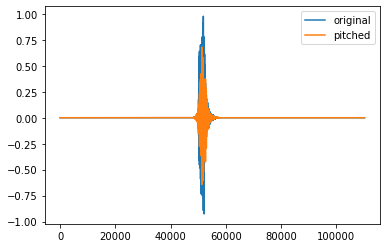

In [78]:
plt.figure()
plt.plot(original, label='original')
plt.plot(pitched[0], label='pitched')
plt.legend()
plt.savefig('originalvspitch')
plt.show()

In [84]:
original = audio

segments = []
segment_labels = []
augmented_spec = []
new_labels = []

# Normalize the raw data
norm_factor = np.percentile(original, 99) - np.percentile(original, 5)
raw_audio = original / norm_factor

# normalized
IPython.display.Audio(raw_audio, rate=22050)

In [89]:
from tqdm import tqdm

bands=60
frames=41

# Convert audio to melspectogram
melspec = librosa.feature.melspectrogram(raw_audio, n_mels=bands, hop_length=512)

# Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
for idx in range(0, len(logspec[0]) - frames, int(frames/2)):
    segments.append(melspec[:, idx:idx+frames])
    #segment_labels.append(1)

# Check for silent segment
for i, segment in enumerate(segments):

    S = librosa.feature.inverse.mel_to_stft(segment)
    segment_audio = librosa.griffinlim(S)

    # Append only non silent segments and convert into db
    if(np.mean(segment) >= 0.001):
        augmented_spec.append(librosa.core.amplitude_to_db(segment))
        #new_labels.append(segment_labels[i])

In [90]:
print(len(segments))
print(len(augmented_spec))

10
3


## Test silence clipping with noises

In [100]:
# Generate noise augmentation
def Noise_Augmentation(data, number):
    '''
        Input:
            data:              data sample to augment
            number:            number of augmentations
        
        Output:
            augmented_data:    augmented data with noise
    '''
    noise_factor = np.random.uniform(0.001, 0.05, number)
    noise = np.random.randn(number, len(data))
    
    tmp = []
    for n, sample in enumerate(noise):
        tmp.append(noise_factor[n] * sample)
    
    augmented_data = data + tmp
    
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    augmented_data = np.asarray(augmented_data)
    return augmented_data

original = audio

noisy_audio = Noise_Augmentation(original, 1)
IPython.display.Audio(noisy_audio, rate=22050)

In [101]:
segments = []
segment_labels = []
augmented_spec = []
new_labels = []

# Normalize the raw data
norm_factor = np.percentile(noisy_audio, 99) - np.percentile(noisy_audio, 5)
raw_audio = original / norm_factor

# normalized
IPython.display.Audio(raw_audio, rate=22050)

bands=60
frames=41

# Convert audio to melspectogram
melspec = librosa.feature.melspectrogram(raw_audio, n_mels=bands, hop_length=512)

# Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
for idx in range(0, len(logspec[0]) - frames, int(frames/2)):
    segments.append(melspec[:, idx:idx+frames])
    #segment_labels.append(1)

# Check for silent segment
for i, segment in enumerate(segments):

    S = librosa.feature.inverse.mel_to_stft(segment)
    segment_audio = librosa.griffinlim(S)

    # Append only non silent segments and convert into db
    if(np.mean(segment) >= 0.001):
        augmented_spec.append(librosa.core.amplitude_to_db(segment))
        #new_labels.append(segment_labels[i])

In [102]:
print(len(segments))
print(len(augmented_spec))

9
3


## Test Pipeline

In [104]:
def Split_Data_Label(dataset):
    
    
    data = []
    label = []
    
    for i in range (len(dataset)):
        data.append(dataset[i][0])
        label.append(dataset[i][1])

    
    data = np.asarray(data)
    label = np.asarray(label)
    
    return data, label

PATH = 'audio'
raw_files, cvs, labels = Load_RAW(PATH)

f1, f2, f3, f4, f5 = Split_Folds(raw_files, cvs, labels, verbose=True)


100%|██████████| 2000/2000 [01:50<00:00, 18.10it/s]


NameError: name 'to_categorical' is not defined

In [ ]:
# Process without augmentation
f1_data, f1_label = Split_Data_Label(f1)
f1_processed, lf1_processed = Preprocessing(f1_data, f1_label)

In [ ]:
# Augment and save fold-1
augmented_f1 = Data_Augmentation(f1, 2, name='af1', path='Augmented_2/', save=True, noise=True, pitch=True)

In [ ]:
#process augmented
af1_data, af1_label = Split_Data_Label(augmented_f1)
f1_processed, lf1_processed = Preprocessing(af1_data, af1_label)